# NeuroLoops: Exploring Feedback Loops in _C. elegans_
#### Jason Prince
This project explores the role of feedback circuits in the nervous system of _C. elegans_ using the connectivity graphs in the [WormAtlas](http://www.wormatlas.org/) database.  Special thanks to Russ Poldrack for notebook starter code in his [Brain Networks Course](https://github.com/BrainNetworksCourse).

## Feedback Loops as State Machines
Most forms of digital memory and state persistence in computers utilize feedback loops.  I was curious to see if there was any consistent structure to feedback loops in the _C. elegans_ connectome.  Given the availability of open graph analysis packages like [NetworkX](https://networkx.github.io/), I wanted to classify all the simple cycles that make up a directed graph of synaptic connections.  A simple cycle is defined as a path through a graph where the only repeated node is the first and last.  In a directed graph, such cycles could relate to feedback loops in the neural circuitry of _C. elegans_.  I set out with the following questions about cycles in this well-documented nematode:

- **Does cyclicity vary for each community?**  Some communities might have relatively low cyclicity, suggesting those communities are responsible for immediate processing rather than state persistence.  Communities that have higher cyclicity than others might be primarily responsible for maintaining state.  If communities are uniformly cyclic, this would suggest that state persistence and processing are interwoven throughout the network.  I hypothesize that some communities are highly cyclic and some communities are not very cyclic.
- **Is the rich club more cyclic than the organism as a whole?**  If cyclicity is more apparent amongst critical connection hubs, this might suggest that state persistence occurs more at higher level behavior functions than in lower-level processing intermediates.  If communities are more internally cyclic than connections amongst critical hubs, this might indicate that state persistence happens locally in the information processing hierarchy.  I hypothesize that the rich club will be highly cyclic, but that there may still be local communities that are more cyclic than the rich club.
- **What types of neurons tend to have more cyclicity?** I hypothesize that interneurons will have the highest cyclicity of the different neuron types, as they seem to be better candidates for high-level state persistence than sensory or motor neurons.
- **Are there common junctions in the larger cycles?**  If there is a set of neurons that appear often in the largest cycle, these nodes might be critical information pathways involved in state persistence.  I hypothesize that there will be a small set of nodes that appear in a high number of cycles, and additionally, these nodes will likely be part of various rich clubs.
- **Do the neurons that make up cycles vary in community or type?**  Are cycles typically all one type of neuron, or do cycles tend to have variation in the types of neurons they include?  Do cycles tend to stay local within communities, or are the connections between different communities where most cycles occur?  I hypothesize that cycles will generally contain mostly nodes of a single type.

In [1]:
# Notebook setup
import pandas as pd
from sklearn import cluster
import numpy as np
import os, sys, operator, scipy.stats, json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats
from networkx.algorithms import community
from collections import Counter
from math import factorial
%matplotlib inline

### Loading the Connectome
WormAtlas provides an edgelist of the neural connections in _C. elegans_.  Each entry tabulates the two neurons, type of connection, and number of synapses present.  There are three main types of connection: chemical connections (directed), electrical junctions (undirected), and neuromuscular junctions (which receive from only one neuron).  For the purposes of developing a directed graph between neurons, I built a graph out of only chemical synapses.  This excluded a small portion of neurons from the resulting graph, but still demonstrated much of the structure present in the full connectome.  The weight of each edge in the graph was equivalent to the `Nbr` field of the dataset, which encodes the number of synapses between the two neurons.  I then assign an index number to each neuron by sorting them alphabetically.

In [2]:
# I decided not to use electric junctions due to undefined directionality
INCLUDE_ELECTRIC_JUNCTIONS = False
WRITE_GRAPHML_FILE = False

# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details
celegans_connectome=pd.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

# set up the graph
G = nx.DiGraph()
def add_edge_nbr(fn, tn, nbr):
    existing_edge = G.get_edge_data(fn, tn)
    if existing_edge is None:
        G.add_edge(fn, tn, weight=nbr)
    else:
        new_weight = existing_edge['weight'] + nbr
        G[fn][tn]['weight'] = new_weight
for i in celegans_connectome.index:
    entry = celegans_connectome.loc[i]
    fn = entry['Neuron 1']
    tn = entry['Neuron 2']
    nbr = entry['Nbr']
    typ = entry['Type']
    if typ in ['S','Sp']:  # Send or Send-poly
        add_edge_nbr(fn,tn,nbr)
    if typ == 'EJ' and INCLUDE_ELECTRIC_JUNCTIONS:
        add_edge_nbr(fn,tn,nbr)
        add_edge_nbr(tn,fn,nbr)
    # Ignore NMJ and R/Rp entries

# Assign a number to each node via the alphabetical ordering of node_list
node_list = list(G.nodes())
node_list.sort()
# Build a map to associate node names with their index
node_map = {}
for i in range(len(node_list)):
    node_map[node_list[i]] = i
# Creating an undirected graph as well in case it's useful for analysis purposes
Gu = G.to_undirected()

print('Connectome graph contains {} nodes and {} edges.'.format(len(G.nodes()),len(G.edges())))

if WRITE_GRAPHML_FILE:
    nx.write_graphml(G, 'c_elegans.graphml')

Connectome graph contains 279 nodes and 2194 edges.


In [3]:
# Utility Functions

def get_weight_histogram(graph):
    ''' Build a histogram of weights from a weighted graph '''
    return dict(Counter([graph[e[0]][e[1]]['weight'] for e in list(graph.edges)]))

def get_cycle_length_histogram(cycles):
    return dict(Counter([c['ct'] for c in cycles]))

def count_cycles(graph, cutoff=1e7):
    i = 0
    for c in nx.simple_cycles(graph):
        i += 1
        if i > cutoff:
            return '> {}'.format(cutoff)
    return str(i)

def get_node_cluster_map(cluster_nodes):
    ''' Invert a cluster_node set to map node names to cluster index '''
    node_cluster_map = {}
    for cluster in range(len(cluster_nodes)):
        for node in cluster_nodes[cluster]:
            node_cluster_map[node] = cluster
    return node_cluster_map

# From Russ Poldrack, with a few changes
# Note that this is somehow broken, as the matrix is duplicated
# and shifted by half an element when using log-colored scaling.
# I tried to get the colored graph to mask out zeros with black
# pixels, but couldn't figure it out.
def plot_adjmtx(G, bin=False, node_order=None, lines=None):
    plt.figure(figsize=(16,16))
    # Build dataframe
    A = nx.to_numpy_array(G, nodelist=node_order, weight='weight')
    if bin:
        A = (A>0).astype('int')
        cmap='gray'
        plt.imshow(A, cmap='gray')
    else:
        cmap='viridis'
        plt.imshow(A)
        plt.pcolor(A, norm=matplotlib.colors.LogNorm(), cmap='viridis')
        plt.colorbar()
    #A = pd.DataFrame(A, columns=list(G.nodes), index=list(G.nodes))
    # Start plotting
    # set the axes to use name labels rather than numbers
    ax=plt.gca()
    node_list=list(G.nodes) 
    ax.set_yticks(np.arange(len(node_list)))
    ax.set_xticks(np.arange(len(node_list)))
    ax.set_xticklabels(node_list)
    ax.set_yticklabels(node_list)
    # Plot cluster lines
    if lines is None:
        return
    graph_size = A.shape[0]-1
    for line in lines:
        plt.plot([0,graph_size],[line,line],color='w',linewidth=0.5)
        plt.plot([line,line],[0,graph_size],color='w',linewidth=0.5)

# From https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/
def graph_to_edge_matrix(G):
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)
    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        node_index = node_map[node]
        for neighbor in G.neighbors(node):
            neighbor_index = node_map[neighbor]
            edge_mat[node_index][neighbor_index] = 1
        edge_mat[node_index][node_index] = 1
    return edge_mat

### Visualizing the Connectome
Below is a plot of the overall neural graph of _C. elegans_:

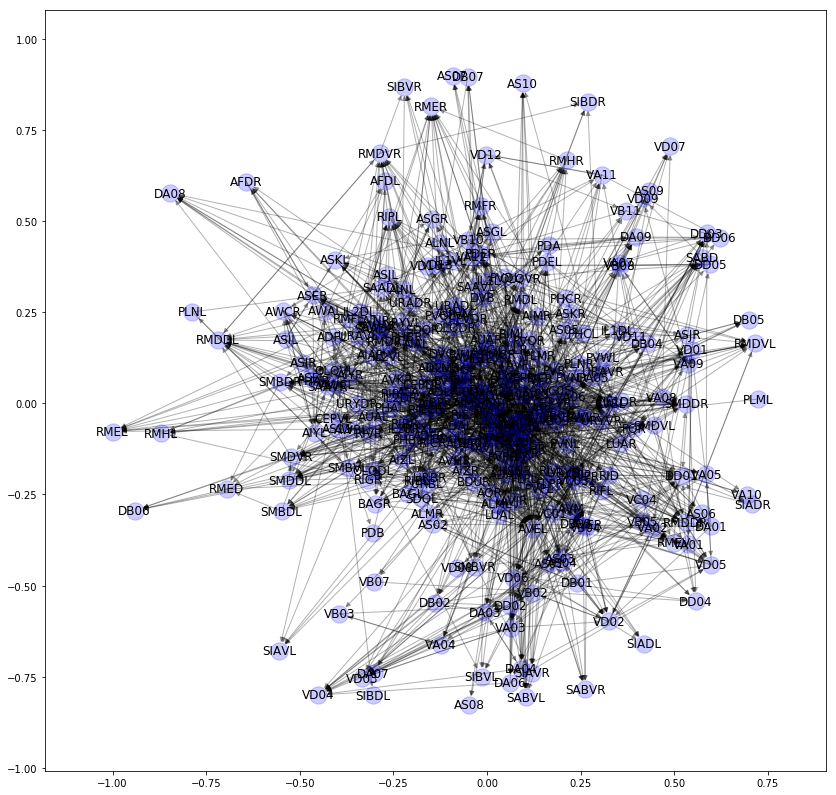

In [3]:
# Build plot
plt.figure(figsize=(14,14))
edge_expansion=12
node_expansion=30
layout = nx.spring_layout(G, weight=None, k=0.4)
#weights=nx.get_edge_attributes(G,'weight')
_=nx.draw_networkx_edges(G,pos=layout, alpha=0.3)
#                      width=[weights[i]*edge_expansion for i in G.edges],)
_=nx.draw_networkx_nodes(G,pos=layout, node_color='blue', alpha=0.2, )
#                       node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=layout)

Below is the binary adjacency matrix.  Note the asymmetry due to directionality.  Also note that nodes are ordered alphabetically here, and the connection patterns are likely due to connectivity of similarly-named neurons.

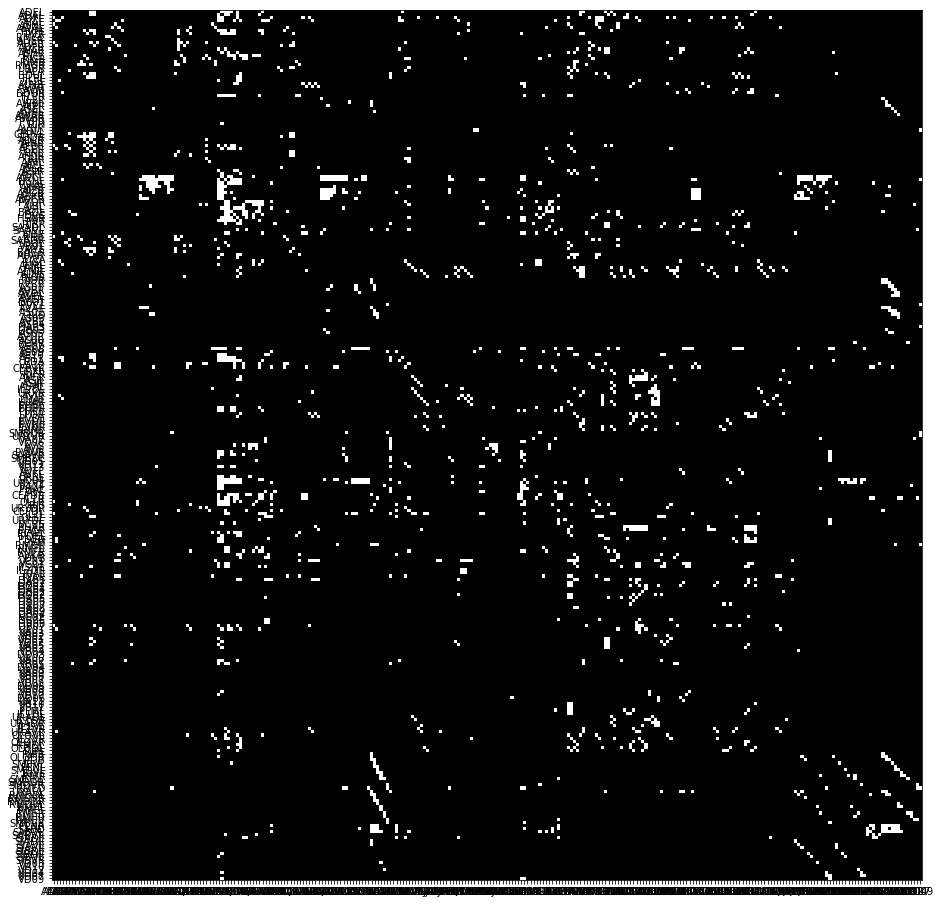

In [6]:
plot_adjmtx(G, True, node_order=node_list)

# Clustering
I tried a number of approaches to clustering before settling on K-means clustering.

### Girvan-Newman Clustering
My first test of clustering the graph used Girvan-Newman clustering to find communities.  This didn't work super well as a clustering method because the majority of the first clusters it found were single-node clusters.  However, this alone was interesting, and raised a new question: how is it that the edges out of a single node can have the highest betweenness centrality even when most of the edges connecting it have been removed?  It wasn't related to this project and likely comes from poor knowledge of graph theory, but I found this surprising.

In [11]:
gn_clusters_gen = community.centrality.girvan_newman(G)
gn_clusters = None
for i in range(15):
    gn_clusters = next(gn_clusters_gen)
    print('Iteration {} yielded communities of sizes {}'.format(i+1, [len(c) for c in gn_clusters]))

Iteration 1 yielded communities of sizes [271, 8]
Iteration 2 yielded communities of sizes [266, 5, 8]
Iteration 3 yielded communities of sizes [265, 5, 8, 1]
Iteration 4 yielded communities of sizes [264, 5, 8, 1, 1]
Iteration 5 yielded communities of sizes [263, 1, 5, 8, 1, 1]
Iteration 6 yielded communities of sizes [89, 174, 1, 5, 8, 1, 1]
Iteration 7 yielded communities of sizes [89, 153, 21, 1, 5, 8, 1, 1]
Iteration 8 yielded communities of sizes [89, 146, 21, 7, 1, 5, 8, 1, 1]
Iteration 9 yielded communities of sizes [89, 144, 21, 7, 2, 1, 5, 8, 1, 1]
Iteration 10 yielded communities of sizes [89, 143, 21, 7, 2, 1, 1, 5, 8, 1, 1]
Iteration 11 yielded communities of sizes [86, 143, 21, 7, 3, 2, 1, 1, 5, 8, 1, 1]
Iteration 12 yielded communities of sizes [86, 142, 21, 7, 3, 1, 2, 1, 1, 5, 8, 1, 1]
Iteration 13 yielded communities of sizes [86, 141, 21, 7, 3, 1, 2, 1, 1, 1, 5, 8, 1, 1]
Iteration 14 yielded communities of sizes [86, 140, 21, 7, 3, 1, 2, 1, 1, 1, 5, 1, 8, 1, 1]
Itera

### Label Propagation Clustering
I tried Label Propagation Clustering, but it did not terminate after an hour of computation.

In [ ]:
lpa_clusters = community.label_propagation.asyn_lpa_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

### Greedy Modularity Clustering
Next, I tried greedy modularity clustering, but the NetworkX implementation seems to be breaking for this graph and I haven't tried any others.  Given the work of [Sohn et al. (2011)](https://dx.doi.org/10.1371%2Fjournal.pcbi.1001139), I have a feeling that modularity clustering might perform better on the _C. elegans_ connectome than K-means clustering.

In [4]:
mod_clusters = community.modularity_max.greedy_modularity_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

IndexError: list index out of range

### K-means Clustering
Finally, I tried K-means clustering and decided to stick with it because of the relatively even distribution of cluster sizes.  The code below tries K-means across a range of values of $k$.  I settled on using $k=9$ due to the sizes of each cluster (maximum size less than 1/3 of overall nodes, and minimum size greater than 2).

In [5]:
def compute_k_means(num_clusters):
    clustergen = cluster.KMeans(n_clusters=num_clusters, n_init=300)
    edge_mat = graph_to_edge_matrix(Gu)
    k_clusters_fit = clustergen.fit(edge_mat)
    k_clusters = list(k_clusters_fit.labels_)
    # Generate cluster node lists
    cluster_nodes = [list() for i in range(num_clusters)]
    for i in range(len(k_clusters)):
        cluster_nodes[ k_clusters[i] ].append(node_list[i])
    cluster_nodes.sort(key=len, reverse=True)
    print('Cluster sizes (k={}): {}'.format(num_clusters, [len(c) for c in cluster_nodes]))
    return cluster_nodes

for k in range(5, 15):
    compute_k_means(k)
print('\nFinal chosen cluster:')
cluster_nodes = compute_k_means(9)
print('Final clusters:\n{}'.format(cluster_nodes))

Cluster sizes (k=5): [125, 87, 37, 19, 11]
Cluster sizes (k=6): [124, 61, 54, 17, 14, 9]
Cluster sizes (k=7): [111, 60, 54, 19, 16, 12, 7]
Cluster sizes (k=8): [105, 61, 30, 21, 19, 17, 15, 11]
Cluster sizes (k=9): [97, 58, 30, 24, 19, 16, 13, 11, 11]
Cluster sizes (k=10): [105, 47, 28, 26, 20, 18, 13, 12, 8, 2]
Cluster sizes (k=11): [121, 58, 39, 16, 14, 12, 8, 5, 2, 2, 2]
Cluster sizes (k=12): [102, 30, 30, 24, 24, 16, 16, 15, 13, 5, 2, 2]
Cluster sizes (k=13): [103, 35, 30, 24, 19, 14, 12, 11, 11, 8, 6, 4, 2]
Cluster sizes (k=14): [93, 44, 38, 31, 19, 15, 14, 13, 3, 2, 2, 2, 2, 1]

Final chosen cluster:
Cluster sizes (k=9): [80, 60, 28, 27, 23, 21, 16, 14, 10]
Final clusters:
[['ADFL', 'ADFR', 'AFDL', 'AFDR', 'AINL', 'AIYR', 'ALA', 'ALML', 'ALMR', 'ALNL', 'ALNR', 'ASGR', 'ASJL', 'ASJR', 'ASKR', 'AUAR', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'BAGL', 'BDUL', 'BDUR', 'DB04', 'DB07', 'DD04', 'DD05', 'DD06', 'DVB', 'PDA', 'PDB', 'PHAL', 'PHAR', 'PHCR', 'PLML', 'PLNL', 'PLNR', 'PVM', 'PVQL', 'PV

In [5]:
# Force-set this so it remains consistent (k-means returns different results due to random seeds)
cluster_nodes = [['ADFL', 'ADFR', 'AFDL', 'AFDR', 'AINL', 'AIYR', 'ALA', 'ALML', 'ALMR', 'ALNL', 'ALNR', 'ASGR', 'ASJL', 'ASJR', 'ASKR', 'AUAR', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'BAGL', 'BDUL', 'BDUR', 'DB04', 'DB07', 'DD04', 'DD05', 'DD06', 'DVB', 'PDA', 'PDB', 'PHAL', 'PHAR', 'PHCR', 'PLML', 'PLNL', 'PLNR', 'PVM', 'PVQL', 'PVWL', 'RID', 'RIGL', 'RIR', 'RMED', 'RMHL', 'SAAVR', 'SABVR', 'SIADL', 'SIADR', 'SIAVL', 'SIAVR', 'SIBDL', 'SIBDR', 'SIBVL', 'SIBVR', 'SMBDL', 'SMBDR', 'SMBVL', 'SMBVR', 'URYDR', 'VA01', 'VA07', 'VB01', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09', 'VB10', 'VB11', 'VC04', 'VC05', 'VD07', 'VD08', 'VD09', 'VD10', 'VD11', 'VD12'], ['ADER', 'AQR', 'AS01', 'AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS07', 'AS08', 'AS09', 'AS10', 'AS11', 'AUAL', 'AVM', 'DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09', 'DB02', 'DB03', 'DB05', 'DB06', 'DVA', 'FLPL', 'FLPR', 'LUAL', 'LUAR', 'PDEL', 'PDER', 'PHBL', 'PHBR', 'PHCL', 'PLMR', 'PQR', 'PVDL', 'PVDR', 'PVPL', 'PVR', 'PVWR', 'SABD', 'SABVL', 'SDQL', 'SDQR', 'VA02', 'VA03', 'VA04', 'VA05', 'VA06', 'VA08', 'VA09', 'VA10', 'VA11', 'VA12', 'VD13'], ['CEPDR', 'CEPVR', 'IL1DR', 'IL1R', 'IL1VR', 'IL2DR', 'IL2L', 'IL2R', 'IL2VL', 'IL2VR', 'OLLR', 'OLQDR', 'OLQVR', 'RIAR', 'RICR', 'RIH', 'RIPR', 'RIVL', 'RMDVR', 'RMEL', 'RMER', 'RMEV', 'RMHR', 'URADR', 'URAVL', 'URAVR', 'URBR', 'URXR'], ['ADEL', 'BAGR', 'CEPDL', 'CEPVL', 'IL1DL', 'IL1L', 'IL1VL', 'IL2DL', 'OLLL', 'OLQDL', 'OLQVL', 'RIAL', 'RIBL', 'RIPL', 'RIVR', 'RMDDL', 'RMDDR', 'RMDVL', 'RMGL', 'SMDVL', 'SMDVR', 'URADL', 'URBL', 'URXL', 'URYDL', 'URYVL', 'URYVR'], ['ADAL', 'ADLL', 'ADLR', 'AIML', 'AIMR', 'ASHR', 'AVFL', 'AVFR', 'AVG', 'AVHL', 'AVHR', 'AVJL', 'AVJR', 'AVL', 'HSNL', 'HSNR', 'PVNL', 'PVNR', 'PVPR', 'PVQR', 'RIFL', 'RIFR', 'RMGR'], ['ADAR', 'AIZR', 'AVKL', 'AVKR', 'DVC', 'PVT', 'RIBR', 'RICL', 'RIGR', 'RIML', 'RIMR', 'RIS', 'RMDL', 'RMDR', 'RMFL', 'RMFR', 'SAADL', 'SAADR', 'SAAVL', 'SMDDL', 'SMDDR'], ['AIAL', 'AIAR', 'AIBL', 'AIBR', 'AINR', 'AIYL', 'AIZL', 'ASEL', 'ASER', 'ASGL', 'ASHL', 'ASIL', 'ASIR', 'ASKL', 'AWCL', 'AWCR'], ['DB01', 'DD01', 'DD02', 'DD03', 'VB02', 'VC01', 'VC02', 'VC03', 'VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06'], ['AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'PVCL', 'PVCR']]


### Cluster Visualizations
Below is the full graph's connectivity matrix again, this time sorted by clusters.  This was quite surprising, as the smaller clusters tended to be more connected within themselves than the larger clusters, where connections were highly spread.  In particular, the largest cluster seemed to hardly be self-connected at all, making it seem like the cluster where neurons that don't fit into a particular cluster go.

Another interesting observation was directly related to feedback loops.  The second-largest cluster was highly connected to the smallest cluster, but in a peculiar way.  Neurons in the second cluster that were pre-synaptic to the smallest cluster tended not to be post-synaptic to the smallest cluster, whereas the reverse was also true.  This suggests that there are a number of feedback loops between these two clusters.

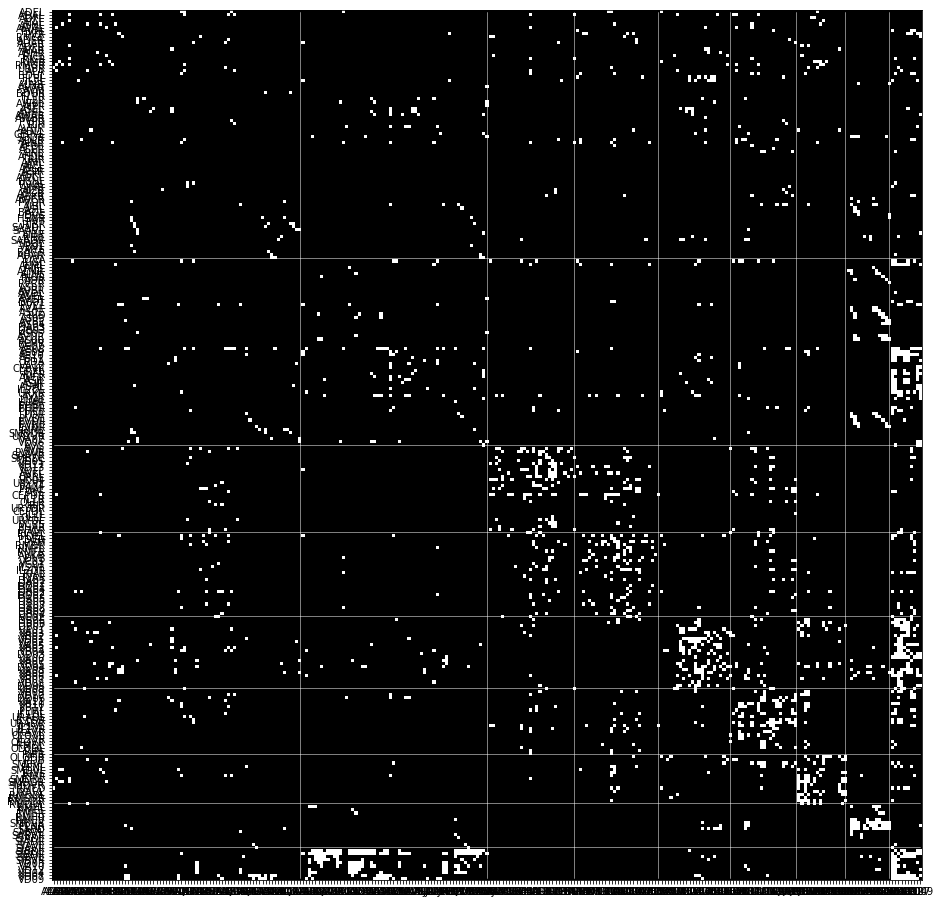

In [11]:
node_order = []
lines = []
for c in cluster_nodes:
    node_order += c
    lines.append(len(node_order)-1)
del lines[-1]
plot_adjmtx(G, True, node_order, lines)

Now that I've settled on a clustering, I generate subgraphs of each cluster.

In [6]:
# Build subgraphs
cluster_subgraphs = []
for c in cluster_nodes:
    sub = G.subgraph(c)
    cluster_subgraphs.append(sub)
# Build a map which associates each node name with its cluster number
node_cluster_map = {}
for cluster in range(len(cluster_nodes)):
    for node in cluster_nodes[cluster]:
        node_cluster_map[node] = cluster

# Inter-Cluster Graph
Given a clustering, I wanted to see what the connectivity between those clusters looked like.  For my first test, I simply included an unweighted directed edge between two clusters if there was a single edge of that direction between two nodes within those clusters.  This turned out to be rather useless, as there was a bidirectional connection between most pairs of clusters.

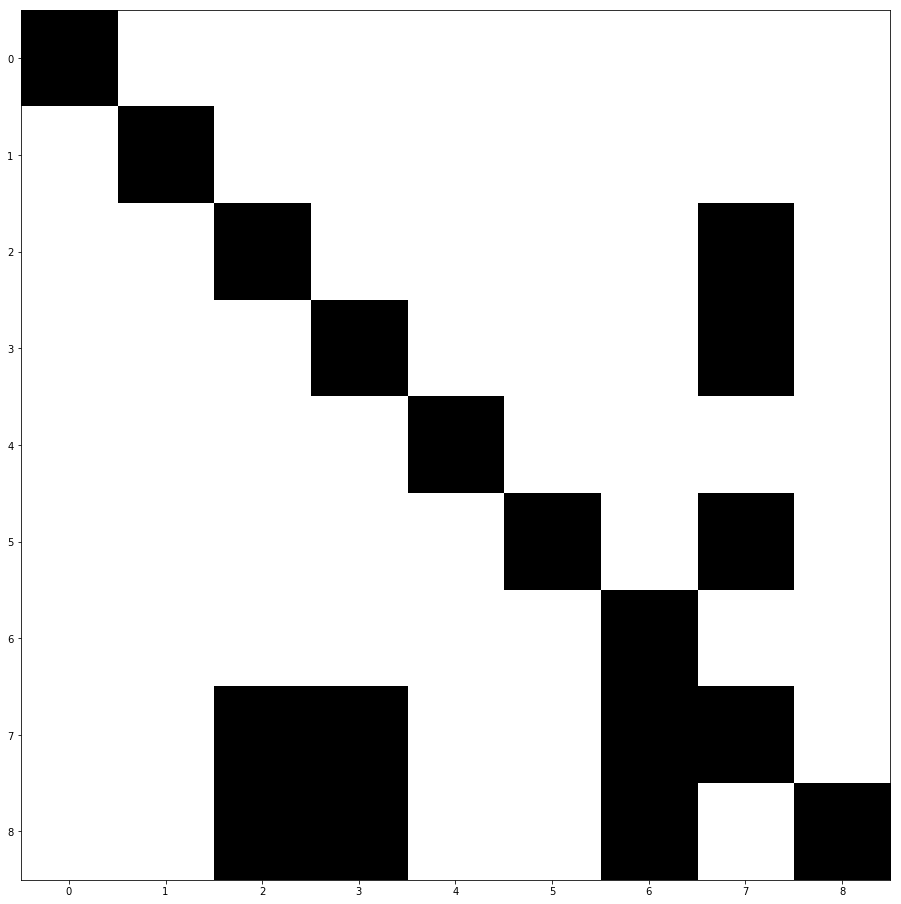

In [10]:
# Build a cluster lookup map indexed by node name
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        C.add_edge(from_cluster, to_cluster)
plot_adjmtx(C, True)

This isn't particularly useful: every cluster has a bidirectional connection to almost every other.  I then tried weighting these connections by the number of connections between them.  This was interesting, as it revealed that the majority of possible cluster-to-cluster edges were instantiated by only a few edges in the full graph, whereas some connections were duplicated nearly 100 times.

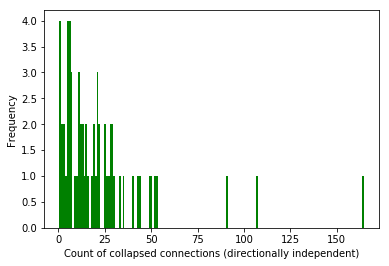

In [7]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
Cw = nx.DiGraph()
for i in range(len(cluster_nodes)):
    Cw.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = Cw.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            Cw.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            Cw[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(Cw)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.xlabel('Count of collapsed connections (directionally independent)')
plt.ylabel('Frequency')
plt.show()

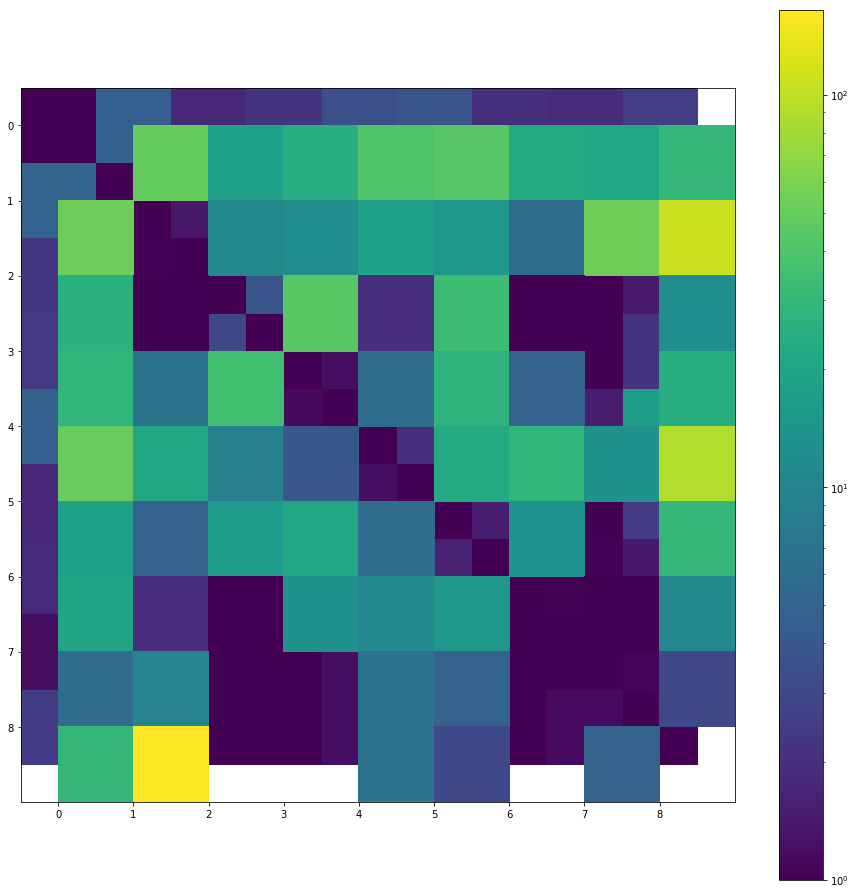

In [18]:
plot_adjmtx(Cw)

From this, I decided to threshold connections, and only add connections that were duplicated some number of times.

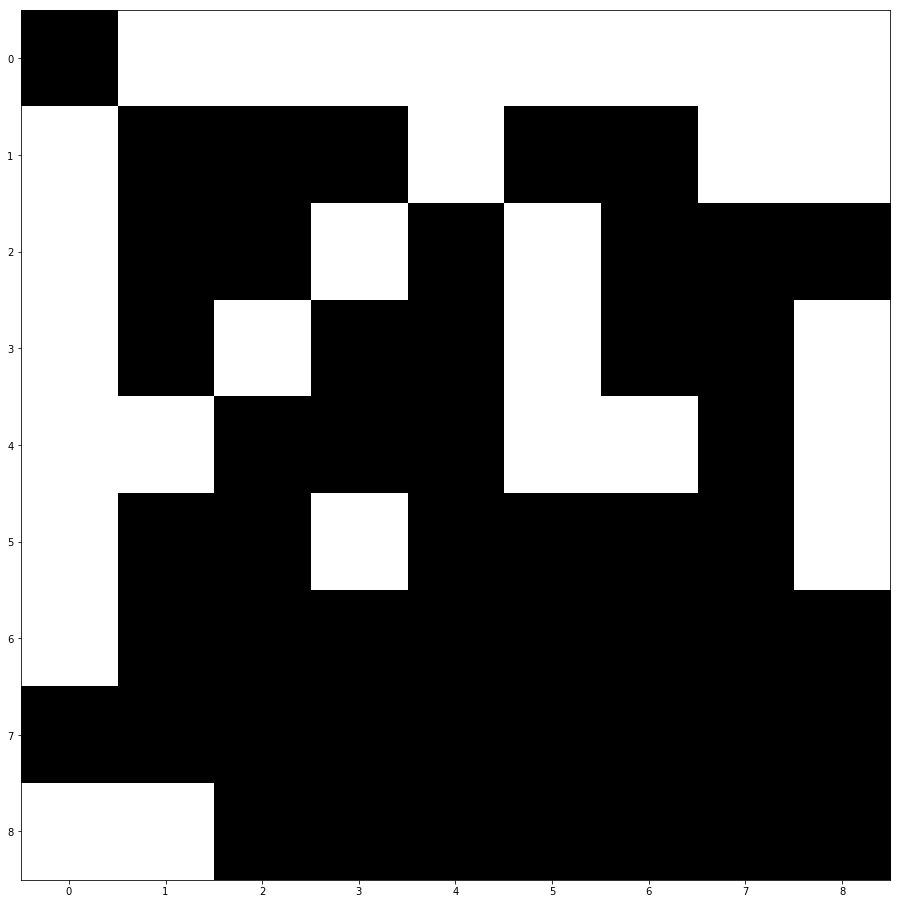

In [8]:
threshold = 18

node_cluster_map = get_node_cluster_map(cluster_nodes)
Cwt = nx.DiGraph()
for i in range(len(cluster_nodes)):
    Cwt.add_node(i)
for edge in list(Cw.edges):
    from_cluster = edge[0]
    to_cluster = edge[1]
    if from_cluster == to_cluster:
        continue
    edge_data = Cw.get_edge_data(from_cluster, to_cluster)
    if edge_data['weight'] >= threshold:
        Cwt.add_edge(from_cluster, to_cluster, weight=1)

weight_hist = get_weight_histogram(Cwt)
plot_adjmtx(Cwt, True)

In [ ]:
plt.figure(figsize=(14,14))
edge_expansion=12
node_expansion=30
layout = nx.spring_layout(Cwt, weight=None, k=0.4)
#weights=nx.get_edge_attributes(G,'weight')
_=nx.draw_networkx_edges(Cwt,pos=layout, alpha=0.3)
#                      width=[weights[i]*edge_expansion for i in G.edges],)
_=nx.draw_networkx_nodes(Cwt,pos=layout, node_color='blue', alpha=0.2, )
#                       node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(Cwt,pos=layout)

# Enumerating All Cycles
I first tried to search for all cycles in the connectome by brute force, but this filled up my hard drive and crashed after identifying over 6 million cycles (over 11 gigabytes of cycles with no compression).  This meant analysis of cycles individually would be intractable given my current setup, but see the discussion below for ways I considered to work around this.

In [ ]:
raise NotImplementedError  # This cell is not meant to be run!
with open('cycles.txt','a') as f:
    f.write('cycles = [\n')
    i = 0
    for c in nx.simple_cycles(G):
        line = '{},'.format(repr(c).replace(' ',''))
        f.write(line)
        i += 1
        if i % 1e5 == 0:
            print('Found {} cycles'.format(i))
        f.write(']\n\n\n')

# Cycle Analysis of Subgraphs
Below is the function I used to analyze cycles in subgraphs.

#### Cycle length histograms
The function first computes a histogram of cycle lengths within each subgraph.  This histogram is plotted, revealing the bell shape of these distributions.  It reports the minimum, maximum, and mode of cycle lengths in the subgraph.

#### Cycle count normalization
To normalize cycle counts against possible counts for a subgraph, I needed to compute the total number of cycles possible in each group.  I found [this StackExchange question](https://math.stackexchange.com/questions/1363963/number-of-cycles-in-complete-graph), but it was only for undirected graphs and the formulas severely undercounted the number of cycles.  I finally decided to estimate the possible number of cycles using $k!$ where $k=$ the number of nodes thanks to Shaull's answere [here](https://cs.stackexchange.com/questions/10427/number-of-cycles-in-a-graph).

I will also note that in my first attempt, I used B2C's equation, which assumes the graph is complete and then counts every subset of 2 or more nodes:

$C_{total} = \sum_{i=2}^k \binom{k}{i} $ where $k=$ the number of nodes.

This revealed an interesting observation, which is that iterations in the middle of the range yielded many more cycles of medium length than cycles of small and large length (the binomial function returns its largest values when $i$ is near the middle of its range, and tails out such that $\binom{k}{0}=1$ and $\binom{k}{k}=1$).  This might explain the shape of cycle length histograms in each subgraph.


In [9]:
def analyze_subgraph(g, cluster_name=''):
    print(' +++  {}  +++'.format(cluster_name))
    print('Nodes = {}'.format(len(g.nodes)))
    
    cycle_lengths = []
    for c in nx.simple_cycles(g):
        cycle_lengths.append(len(c))
    num_cycles = len(cycle_lengths)
    len_hist = dict(Counter(cycle_lengths))
    print('Cycles = {}'.format(num_cycles))
    
    len_mode = max(len_hist.keys(), key=(lambda key: len_hist[key]))
    # Longest possible cycle length is the number of nodes in the subgraph
    mode_percent_of_max = (100.0 * len_mode) / len(g.nodes)
    print('Mode of cycle lengths = {:d}; this traverses {:.2f}% of the graph'.format(len_mode, mode_percent_of_max))
    print('Smallest cycle = {}, longest cycle = {}'.format(min(cycle_lengths),max(cycle_lengths)))
    
    # See note above about max_cycle calculation
#     Original function: $C_{total} = \sum_{i=2}^k \binom{k}{i} $ from B2C
#     sumval = 0
#     for i in range(2,k+1):
#         sumval += factorial(k) // (factorial(k-i) * factorial(i))
#     return sumval
    max_cycles = factorial(len(g.nodes))
    cycle_utilization = (100.0 * num_cycles) / max_cycles
    print('Cycle utilization = {:.2f}% of {:d} possible cycles'.format(cycle_utilization, max_cycles))
    
    width = 1.0
    plt.bar(len_hist.keys(), len_hist.values(), width, color='g')
    plt.xlabel('Cycle length')
    plt.ylabel('Frequency')
    plt.show()
    
    print('\n')

### Cluster connection analysis
I first analyzed the connections between clusters in the inter-cluster connection subgraph which used weight as a connection threshold.

 +++  Inter-Cluster Graph  +++
Nodes = 9
Cycles = 89
Mode of cycle lengths = 4; this traverses 44.44\% of the graph
Smallest cycle = 2, longest cycle = 8
Cycle utilization = 0.02\% of 362880 possible cycles


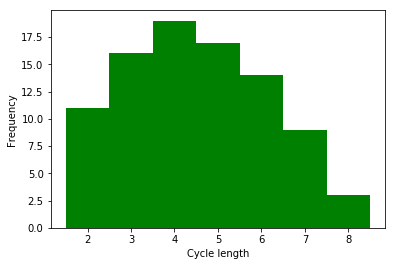

In [15]:
analyze_subgraph(Cwt, 'Inter-Cluster Graph')

### Cluster analysis
I analyzed each cluster in my final clustering.  To compare cycles, here are the number of cycles found in each cluster compared to the subgraph's order:

In [7]:
cycle_counts = []
for sub in range(len(cluster_subgraphs)):
    cycle_counts.append(count_cycles(cluster_subgraphs[sub]))
    print('Cluster {} has: {} nodes, {} cycles'.format(sub, len(cluster_subgraphs[sub]),
                                                       cycle_counts[sub]))
print(cycle_counts)

Cluster 0 has: 80 nodes, 43 cycles
Cluster 1 has: 60 nodes, 23 cycles
Cluster 2 has: 28 nodes, 436 cycles
Cluster 3 has: 27 nodes, 234 cycles
Cluster 4 has: 23 nodes, 2726948 cycles
Cluster 5 has: 21 nodes, 19848 cycles
Cluster 6 has: 16 nodes, 1452 cycles
Cluster 7 has: 14 nodes, 34 cycles
Cluster 8 has: 10 nodes, 6140 cycles


The variation in number of cycles here is quite interesting.  It is likely that the two largest clusters lack cycles due to the small number of connections within themselves, as revealed in the cluster-ordered adjacency matrix above.  Clusters 4 and 8 have the greatest number of cycles per node by far.  They also appear to be the most densely connected subgraphs, which could explain the number of cycles.

Let's analyze the cycle distributions within each of these clusters:

In [ ]:
for i in range(len(cluster_subgraphs)):
    analyze_subgraph(cluster_subgraphs[i], 'Cluster {}'.format(i))

### Rich club analysis
Next, I analyzed cycles within the _C. elegans_ rich club.  I determined the rich club by filtering out nodes with degree less than 50, which left a subgraph of only 10 highly-connected nodes.

In [10]:
cutoff=50
G_highdegree=G.copy()
deg = dict(G_highdegree.degree())
to_remove = [n for n in deg if deg[n] <= cutoff]
G_highdegree.remove_nodes_from(to_remove)
print('RC has {} nodes with cutoff {}'.format(len(G_highdegree.nodes),cutoff))

RC has 10 nodes with cutoff 50


In [ ]:
nx.draw_spring(G_highdegree, with_labels=True)

In [2]:
analyze_subgraph(G_highdegree, 'High Degree Subgraph')

NameError: name 'analyze_subgraph' is not defined

# Discussion & Future Directions
Finding cycles in a graph is an NP-hard problem.  But with only 302 neurons, it may still be feasible to generate and process the full list of cycles with a better computational setup.  Even with the limited analysis I did, an interesting pattern emerged.

I discovered that within clusters and subgraphs, the frequency of cycle lengths often approximates a normal distribution, with the majority of subgraphs having a mode cycle length that encompasses about 50% of the subgraph.  These distributions surprised me.  I am unsure if they are fundamental features of cycles in general, or if these findings are specific to the structure of the _C. elegans_ network.  With relation to my questions, this suggests that cycles within _C. elegans_ are functioning most often as semi-local feedback loops.  Whether this translates to the connectome as a whole cannot be determined until statistics are computed for cycles across the entire graph.

_C. elegans_ is useful because we have a complete connectome, but results here may not be very relevant to studies of mammalian brains due to different functioning of the neurons.  Additionally, I am unsure if it is currently known whether particular synapses are excitatory or inhibitory.  Knowing this is crucial for study of feedback loops due to the differences in behavior between negative and positive feedback systems.

Even within this project, there are many areas for improvement.

#### Finding cycles
My main issue with finding cycles was that I did not have enough local memory to enumerate every cycle in the connectome.  My brute force approach could have been aided by using numerically indexed neurons rather than neuron names; also, by running on a cluster with more memory.  But there are a number of improvements to be made on this approach.  Since cycles are generated iteratively, it is possible to resolve the memory bottleneck by computing aggregates along the way rather than generating the complete set of cycles first.  Many classifications I want to explore could be computed by maintaining a matrix of edges and nodes that counts the number of times they co-occured in a cycle.  Additionally, cycles could be classified and filtered on the fly.  Some metrics that might be worth computing histograms for include:
 - Connection weight of the weakest and strongest links by synapse count (would allow removing weak edges from the initial graph in order to simplify the search algorithm)
 - Distribution of neuron types
 - Distribution of cluster makeup of cycles
 
#### Better clusters
There are many known clusterings of neurons within _C. elegans_.  For instance, [Towlson et al. (2013)](https://dx.doi.org/10.1523%2FJNEUROSCI.3784-12.2013) have studied the rich club network and [Sohn et al. (2011)](https://dx.doi.org/10.1371%2Fjournal.pcbi.1001139) have studied a modularity-based clustering of connectome.  Additionally, it may be interesting to group neurons by their anatomical position and structure.

#### Classifying found cycles
Many more metrics could be generated to classify cycles.
 - Classify based on the maximum, minimum, and mean path weight.
 - Classify based on the types of neurons making up a cycle.
 - Classify based on the distribution of cluster membership of a cycle's neurons.  Which cycles tend to gravitate to a particular home cluster?  What proportion of cycles lie strictly within a single cluster?

#### Exploring how cycles interact with one another
 - Are there particular edges which have more cycles through them than others?  
 - Do cycles tend to share paths with each other, or are there distinct groups of cycles that don't interact much?  It may be useful to construct a graph where each cycle is a node and edges are weighted by the number of neurons and synapses shared by two cycles.
 - Group cycles by edit distance, since it is likely that there are many cycles which differ in only a very small subset of nodes and might play a similar role in overall feedback loop structure.

#### Classifying clusters based on the cycles that make them up
 - How many cycles are completely enclosed in each cluster?
 - How many cycles pass through the cluster but are not contained in it?
 - Can be used to make comparisons with cluster function as studied by Towlson et al. and Sohn et al.

#### Other methods to explore feedback loops
Studying simple cycles may not be as useful as simply exploring the dynamics of information flow in _C. elegans_.  This could be accomplished through a simulation of the _C. elegans_ nervous system, such as that being developed by [OpenWorm](http://openworm.org/).  Such dynamic analysis could provide more concrete evidence for how feedback loops actually play a role in the behavior of _C. elegans_.

# Conclusion
_C. elegans_ is a useful tool for studying basic structure of biological neural networks, and there are certainly a range of questions to explore concerning simple cycle structure.  Whether these will actually say anything useful about feedback loops remains to be seen.
